In [21]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



Cannot get token. Quitting.


In [19]:
ls -l

total 0


In [22]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

/content
mkdir: cannot create directory ‘drive’: File exists
/content/drive
mkdir: cannot create directory ‘MyDrive’: File exists
/content
/
Cannot get token. Quitting.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=a6a1c74b9644db9e3fa2751bc0750a32a9264a81d854ed22b4f33490acc185a0
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [4]:
import wandb
wandb.login()
#ec0fa02abb6680e2e41f9e94ffb3c3a636ca9007

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
%cd  '/content/drive/MyDrive/AI Project/Dataset1/'
# # /content/drive/MyDrive/AI Project/Dataset1/PlantVillage

/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1


In [6]:
%pwd

'/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1'

In [7]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator 

In [8]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage'
width=256
height=256
depth=3
batch_size = 32

In [9]:
train_config = {"EPOCHS" : 25,
"INIT_LR" : 1e-3,
"BS" : 32,
"default_image_size" : tuple((256, 256)),
"image_size" : 0,
"directory_root" : '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage',
"width":256,
"height":256,
"depth":3,
"batch_size" : 32}

In [10]:
run = wandb.init(project="shuffleNet2", config=train_config)

wandb: Currently logged in as: shiransilva143 (shiranaai). Use `wandb login --relogin` to force relogin


In [11]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:


data_path = '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage_15 classes/'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [13]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.3, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.7, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [14]:
print(len(dataset['train']))
print(len(dataset['valid']))
print(len(dataset['test']))

14411
1853
4324


In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=False,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train/valid/test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 32,  train/valid/test : 451 / 58 / 136


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
#class distribution test

count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)

v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

[ 707. 1012.  682.  633.  121. 1510.  729. 1332.  678. 1246. 1197.  994.
 2198.  268. 1104.]
[ 82. 144.  98.  94.  19. 197.  89. 168.  74. 152. 146. 122. 301.  27.
 140.]


In [ ]:
# imgtest = None
# for images, labels in dataloaders['train']:  
#     print(images)
#     print(labels)
#     imgtest = images[3]
#     print(imgtest.shape)
#     break

# imgtest = imgtest.numpy()
# imgtest = np.moveaxis(imgtest, 0, -1)
# imshow(imgtest)

In [20]:
# modeling
from torchvision import models
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.shufflenet_v2_x2_0(weights = None,num_classes=classes,progress=True)
        
        for parameter in self.model.parameters():
            parameter.require_grad = False
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [21]:
dataloaders['train'] = DeviceDataLoader(dataloaders['train'], device)
dataloaders['valid'] = DeviceDataLoader(dataloaders['valid'], device)
dataloaders['test'] = DeviceDataLoader(dataloaders['test'], device)

In [22]:
model = to_device(PlantDiseaseModel(classes=15), device) 
# model = PlantDiseaseModel(classes=len(count))
optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()
model


PlantDiseaseModel(
  (model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

In [ ]:
# # defining the model and moving it to the GPU
# model = to_device(PlantDiseaseModel(len(train.classes)), device) 
# model

In [23]:
device


device(type='cuda')

In [24]:
num_epochs = 10
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0
dev = device
since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    wandb.log({'epoch':(epoch+1)/num_epochs,'training_loss': trn_loss/batch_num['train'],'validation_loss': val_loss/batch_num['valid']})
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet2/best_model.pt')
print("model saved")

epoch: 1/10 | trn loss: 2.6786 | val loss: 2.6472 | 1m 23s elapsed
best model updated-epoch: 1 | val_accuracy: 7.3326
epoch: 2/10 | trn loss: 2.6375 | val loss: 2.6156 | 2m 46s elapsed
best model updated-epoch: 2 | val_accuracy: 9.1234
epoch: 3/10 | trn loss: 2.6159 | val loss: 2.5961 | 4m 8s elapsed
best model updated-epoch: 3 | val_accuracy: 9.9946
epoch: 4/10 | trn loss: 2.5958 | val loss: 2.5806 | 5m 29s elapsed
best model updated-epoch: 4 | val_accuracy: 10.5270
epoch: 5/10 | trn loss: 2.5808 | val loss: 2.5678 | 6m 54s elapsed
best model updated-epoch: 5 | val_accuracy: 10.7690
epoch: 6/10 | trn loss: 2.5626 | val loss: 2.5390 | 8m 17s elapsed
best model updated-epoch: 6 | val_accuracy: 12.9712
epoch: 7/10 | trn loss: 2.5317 | val loss: 2.5111 | 9m 40s elapsed
best model updated-epoch: 7 | val_accuracy: 14.3990
epoch: 8/10 | trn loss: 2.5076 | val loss: 2.4864 | 11m 1s elapsed
best model updated-epoch: 8 | val_accuracy: 14.7862
epoch: 9/10 | trn loss: 2.4885 | val loss: 2.4685 | 

In [25]:
!pwd

/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1


In [40]:
print(trn_loss_list)

[2.678620256500075, 2.6375206383791836, 2.6158669068913767, 2.5958127039763457, 2.5808198467855177, 2.5625752620316398, 2.5317125331007455, 2.507599964374449, 2.4884719690039523, 2.4663947416250562]


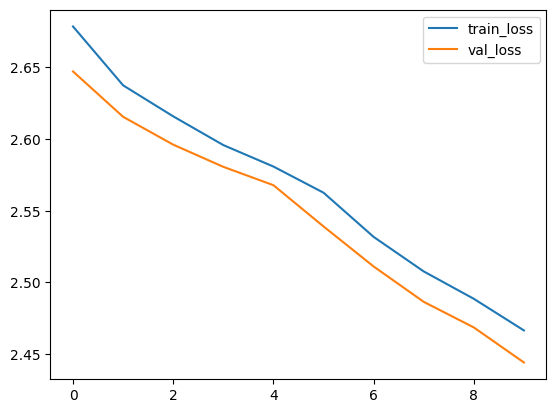

In [39]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

In [55]:
trn_acc_list = torch.randn(10)
trn_acc_list.tolist()

[0.6433661580085754,
 0.13902074098587036,
 -0.22364720702171326,
 -0.00019678664102684706,
 0.8783599138259888,
 0.9036880731582642,
 0.06276630610227585,
 -0.23432326316833496,
 0.6626657843589783,
 0.08502833545207977]

In [56]:
val_acc_list = torch.randn(10)
val_acc_list.tolist()

[-1.3176971673965454,
 0.22509650886058807,
 -0.39146268367767334,
 -1.7543100118637085,
 0.5120185613632202,
 -0.42524799704551697,
 -1.9265385866165161,
 0.19447508454322815,
 1.7329208850860596,
 -1.3502330780029297]

tensor([ 6.4337e-01,  1.3902e-01, -2.2365e-01, -1.9679e-04,  8.7836e-01,
         9.0369e-01,  6.2766e-02, -2.3432e-01,  6.6267e-01,  8.5028e-02])


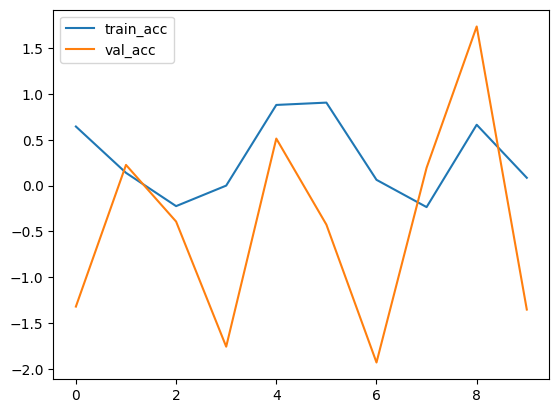

In [57]:
print(trn_acc_list)
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [ ]:
# best_model = PlantDiseaseModel()
# best_model.load_state_dict(torch.load('best_model.pt'))


In [58]:
%pwd

'/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1'

In [61]:
corrects = 0
total = 0
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: ignored

In [60]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model = best_model.to(device)
# Set the model to evaluation mode
best_model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in dataloaders['test']:
    images, labels = images.to(device), labels.to(device)
    # Predict the labels
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))
print('Confusion matrix:\n', conf_matrix)

Precision: 0.1070, Recall: 0.2299, F-score: 0.1406
Confusion matrix:
 [[  0   0   0   0   0   5   0   0   0  88  95   0  30   0   0]
 [  0   0   0   0   0  67   0   0   0  94 142   0  19   0   0]
 [  0   0   0   0   0   3   0   0   0 151  76   0   0   0   0]
 [  0   0   0   0   0  40   0   0   0  32 106   0   5   0   0]
 [  0   0   0   0   0   0   0   0   0   8  11   0   3   0   0]
 [  0   0   0   0   0 396   0   0   0   6   6   0  12   0   0]
 [  0   0   0   0   0  80   0   0   0  33  44   0  25   0   0]
 [  0   0   0   0   0 138   0   0   0  70 150   0  51   0   0]
 [  0   0   0   0   0  57   0   0   0  64  67   0  12   0   0]
 [  0   0   0   0   0  20   0   0   0 323  29   0   1   0   0]
 [  0   0   0   0   0  15   0   0   0  12 231   0  75   0   0]
 [  0   0   0   0   0  30   0   0   0  74 183   0   1   0   0]
 [  0   0   0   0   0  24   0   0   0   0  14   0 671   0   0]
 [  0   0   0   0   0   0   0   0   0  54  23   0   1   0   0]
 [  0   0   0   0   0 135   0   0   0  42 173   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


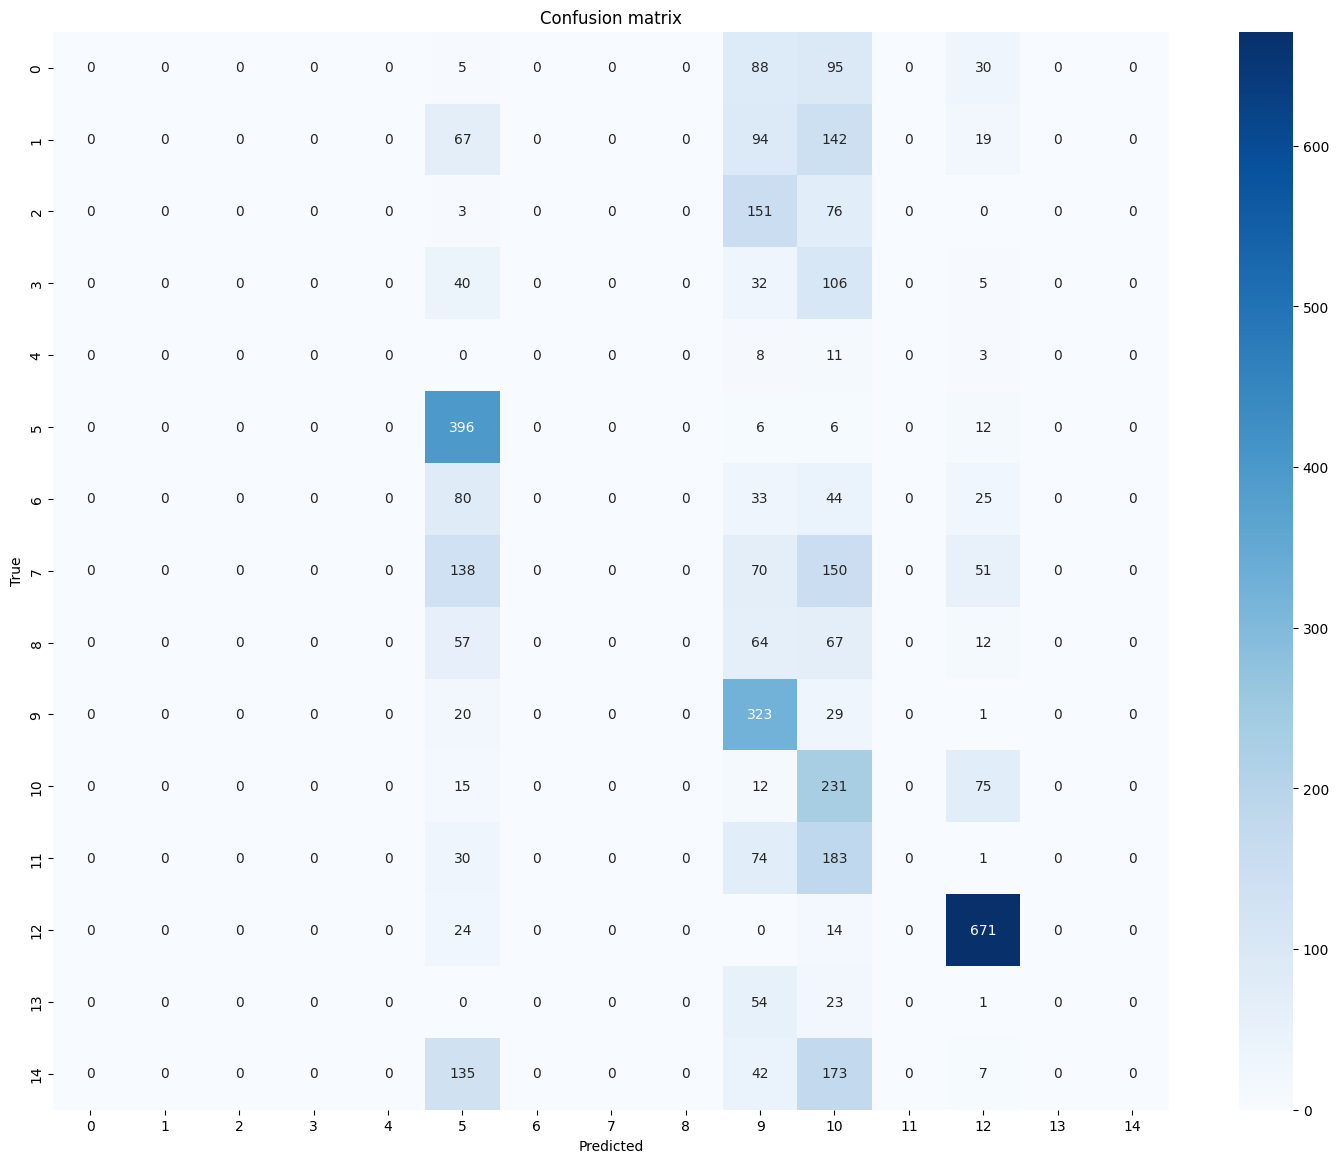

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
